# 0 Outline
1. Data Process Functions or Class, APIs:
    - can input from excel or others.
    - Output 2-D data points.
        - 1th dimention indicates single data point(x,y,z,t,value).
        - 2th dimention indicates the number of data points.
    - Every data point has form (x,y,z,t,value), where x,y,z is spatial corordinate, t is temporal corordinates, and value is function(to be solved) value.
    - be Tensor.
    - can assign accuracy for each number.
    - can assign whether gradient 'on' or 'off'.

2. Model Functions or Class, APIs:
    - models

3. Tool Functions or Class, APIs:
    - train
    - evaulate

4. Visualization Functions or Class, APIs:


关于数据集的一些信息
pass
可能人为取点
- 线段
- 或cube
- 或圆盘

方程形式：
$$
\begin{aligned}
\begin{cases}
u_t(x,t) &= \triangle u(x,t),\quad t\in(0,T],\quad x\in\Omega \subset \mathbf{R}^n \\
u(x,t) &= 0 ,\quad x\in \partial\Omega\times (0,T] \\
u(x,0) &= \sin(x) \quad x\in\Omega
\end{cases}
\end{aligned}
$$

先考虑$\Omega = [0,\pi]$以及时间为$(0,10]$的情形。
此时上述形式的方程有解析解$u(x,t) = \sin(x)\exp(-t)$

# import modules involved

In [109]:
import torch
import pandas
import torch.nn as nn
import collections
import numpy as np
import matplotlib.pyplot as plt
import random

import itertools

In [110]:
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [111]:
same_seeds(12)

有价值的种子：3 6 
可以用的种子：12

# Data Functions or Classes.

In [112]:
class DataProcess:
    """
    数据读取与预处理
    主要是数据读取
    流程(以Excel为例)
    1.读取Excel表 (需要Pandas包)
    2.把数据转换成Tensor格式
    3.把数据变成指定形状
        - 二维矩阵
        - 行数代表数据点个数
        - 每一行代表一个数据点，(x,y,z,t,value)
    4.其它要求
        - 区分边界点和内部点
        - 区分训练集和验证集
    """
    def __init__(self,input,output,spatial_dimension):
        pass

    def ReadFromExcel(self,filename):
        pass

# Model Functions or Classes
- model

In [113]:
class MyReLU(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    ReLU^3
    """
 
    @staticmethod
    def forward(ctx, input):
        """
         In the forward pass we receive a Tensor containing the input and return
         a Tensor containing the output. ctx is a context object that can be used
         to stash information for backward computation. You can cache arbitrary
         objects for use in the backward pass using the ctx.save_for_backward method.
         """
        ctx.save_for_backward(input)
        return (input**3).clamp(min=0)
 
    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        grad_input = (grad_output * 3 * input**2).clone()
        grad_input[input < 0] = 0
        return grad_input

In [114]:
class HeatEqModel(nn.Module):
    """
    - 确定深度模型
    - 前向函数
    - 需要需要确定方程的系数
    """
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        f_boundary,
        f_ini,
        u_real = None,
        act=MyReLU  #torch.nn.Tanh
    ):
        super(HeatEqModel, self).__init__()

        self.f_boundary = f_boundary
        self.f_ini = f_ini
        self.u_real = u_real
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.depth = depth
        self.act = act

        layers = [('input', torch.nn.Linear(self.input_size, self.hidden_size))]
        layers.append(('input_activation', self.act()))
        for i in range(self.depth): 
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(self.hidden_size, self.hidden_size))
            )
            layers.append(('activation_%d' % i, self.act()))
        layers.append(('output', torch.nn.Linear(self.hidden_size, self.output_size)))

        layerDict = collections.OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

# Util Functions or Classes
- train
- evalute

In [115]:
torch.cuda.is_available()

True

In [116]:
class Util_testnorm:
    """
    包括但不限于：
    - 数据的处理过程
      - 数据类型 long float
      - 数据存储位置cpu or gpu
    - 模型的实例化
    - 定义损失函数
    - 定义训练过程
    - 定义evaluate过程
    - 
    """
    def __init__(self,xyt_boundary,xyt_ini,xyt_In,xt_test,Data = None):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.device = device

        self.boundary = xyt_boundary.detach()
        self.initial = xyt_ini.detach()
        self.In = xyt_In.detach()
        self.xt_test = xt_test.detach()

        self.boundary.requires_grad_()
        self.initial.requires_grad_()
        self.In.requires_grad_()
        self.xt_test.requires_grad_()

        print(self.boundary)
        self.data = Data # Data可以视作一张表。
        self.error = 0
        self.relativeError = 0
        self.loss = 0

        self.model = HeatEqModel(
            input_size=2,
            hidden_size=36,
            output_size=1,
            depth=5,
            f_boundary = lambda x:torch.zeros(x.size()),
            f_ini = lambda x:torch.sin(x),
            u_real = lambda x:torch.sin(x[:,0])*torch.exp(-x[:,1]),
            act=torch.nn.Tanh
        ).to(device)

        self.realvalue = self.model.u_real(self.xt_test).unsqueeze(1)
        self.realvalue_dt = - self.model.u_real(self.xt_test).unsqueeze(1)
        self.realvalue_dx = (torch.cos(self.xt_test[:,0])*torch.exp(-self.xt_test[:,1])).unsqueeze(1)
        self.realvalue_dxdx = - self.model.u_real(self.xt_test).unsqueeze(1)
        
        # 处理数据的过程放到模型外了
        
        self.criterion = torch.nn.MSELoss(reduction='sum')
        self.iter = 0
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1e-3, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )
        
        self.adam1 = torch.optim.Adam(self.model.parameters())
        self.adam2 = torch.optim.Adam(self.model.parameters(),lr = 0.25*1e-5)
        
    def loss_func(self):
        self.adam1.zero_grad()
        self.adam2.zero_grad()
        #self.optimizer.zero_grad()

        # 初边值条件产生的loss_data = loss_boundary + loss_ini.

        # loss_boundary MSE()($\triangle T \cdot \vector{x} + \epsilon \sigma (T^4 - T_{\infty}^4)$ - 0).        
        y_predBoundary = self.model(self.boundary)

        
        loss_boundary = self.criterion(torch.zeros_like(y_predBoundary),y_predBoundary)
        boundary_samples_num = torch.tensor(len(self.boundary)).to("cuda").to(torch.float32).requires_grad_()
        
        loss_boundary = loss_boundary*20./boundary_samples_num

        y_predIni = self.model(self.initial)
        dy_predIni_dx = torch.autograd.grad(inputs=self.initial, outputs=y_predIni,
                                            grad_outputs=torch.ones_like(y_predIni),
                                            retain_graph=True,
                                            create_graph=True)[0][:,0].unsqueeze(1)
        
        dy_predIni_dxdx = torch.autograd.grad(inputs=self.initial, outputs=dy_predIni_dx,
                                            grad_outputs=torch.ones_like(dy_predIni_dx),
                                            retain_graph=True,
                                            create_graph=True)[0][:,0].unsqueeze(1)
        # loss_ini = MSE()(y_predIni,0)
        #print("\n loss_ini\n")
        #print(f"y_predIni{y_predIni}")
        #print(f"torch.full((y_predIni.shape[0],1),0).to(torch.float32){torch.full((y_predIni.shape[0],1),0).to(torch.float32)}")
        loss_ini = self.criterion(y_predIni-torch.sin(self.initial[:,0]).unsqueeze(1),
                                 torch.zeros_like(y_predIni-torch.sin(self.initial[:,0]).unsqueeze(1)).to(torch.float32).to(self.device)
                                 )
        loss_ini += self.criterion(dy_predIni_dx-torch.cos(self.initial[:,0]).unsqueeze(1),
                                   torch.zeros_like(dy_predIni_dx-torch.cos(self.initial[:,0]).unsqueeze(1))
                                   )
        loss_ini += self.criterion(dy_predIni_dxdx+torch.sin(self.initial[:,0]).unsqueeze(1),
                                   torch.zeros_like(dy_predIni_dxdx+torch.sin(self.initial[:,0]).unsqueeze(1))
                                   )
        ini_samples_num = torch.tensor(len(self.initial)).to("cuda").to(torch.float32).requires_grad_()
        loss_ini = loss_ini*torch.pi/ini_samples_num


        y_predIn = self.model(self.In)

        dy_predIn_dx = torch.autograd.grad(inputs=self.In, outputs=y_predIn,
                                                 grad_outputs=torch.ones_like(y_predIn),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
        
        dy_predIn_dt = torch.autograd.grad(inputs=self.In, outputs=y_predIn,
                                                 grad_outputs=torch.ones_like(y_predIn),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,1].unsqueeze(1)

        dy_predIn_dxdx = torch.autograd.grad(inputs=self.In, outputs=dy_predIn_dx,
                                                 grad_outputs=torch.ones_like(dy_predIn_dx),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)

        #print("\n loss pde \n")
        #print(f"dy_predIn_dt*self.model.specific_heat*self.model.mass_density{dy_predIn_dt*self.model.specific_heat*self.model.mass_density}")
        #print(f"self.model.thermal_conductivity*(dy_predIn_dxdx + dy_predIn_dydy{self.model.thermal_conductivity*(dy_predIn_dxdx + dy_predIn_dydy)}")
        loss_pde = self.criterion(dy_predIn_dt-dy_predIn_dxdx,
                                  torch.zeros_like(y_predIn)
                                  )
        
        In_samples_num = torch.tensor(len(self.In)).to("cuda").to(torch.float32).requires_grad_()
        loss_ini = loss_pde*10.*torch.pi/In_samples_num

        loss = loss_pde + loss_boundary + loss_ini
        #print(f"loss_boundary{loss_boundary}\nloss_ini{loss_ini}\nloss_pde{loss_pde}")
        loss.backward()

        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
#        print(f"realvalue{self.realvalue.size()} realvalue_dt{self.realvalue_dt.size()} realvalue_dx{self.realvalue_dx.size()} realvalue_dxdx{self.realvalue_dxdx.size()}")
        if self.iter == 1:
            test_first_grad = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                                 grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                                 retain_graph=True,
                                                 create_graph=True)
            test_dx = test_first_grad[0][:,0].unsqueeze(1)
            test_dt = test_first_grad[0][:,1].unsqueeze(1)
            
            DtestDx_first_grad = torch.autograd.grad(inputs=self.xt_test, outputs=test_dx,
                                                 grad_outputs=torch.ones_like(test_dx),
                                                 retain_graph=True,
                                                 create_graph=False)
            test_dxdx = DtestDx_first_grad[0][:,0].unsqueeze(1)

            error = self.criterion(self.realvalue,self.model(self.xt_test))+self.criterion(self.realvalue_dt,test_dt)+self.criterion(self.realvalue_dx,test_dx)+self.criterion(self.realvalue_dxdx,test_dxdx)
            test_samples_num = torch.tensor(len(self.xt_test)).to("cuda").to(torch.float32).requires_grad_()
            self.relativeError = error / self.criterion(self.realvalue,torch.zeros_like(self.realvalue))
            print(self.relativeError)
            self.relativeError = self.relativeError.unsqueeze(0)
            print(self.relativeError)
            error = 10*torch.pi/test_samples_num * error
            self.error = error.unsqueeze(0)

#            print(f"test_dx{test_dx.size()} test_dt{test_dt.size()} test_dxdx{test_dxdx.size()} realvalue{self.realvalue.size()} realvalue_dt{self.realvalue_dt.size()} realvalue_dx{self.realvalue_dx.size()} realvalue_dxdx{self.realvalue_dxdx.size()}")
        else:
            test_first_grad = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                                 grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                                 retain_graph=True,
                                                 create_graph=True)
            test_dx = test_first_grad[0][:,0].unsqueeze(1)
            test_dt = test_first_grad[0][:,1].unsqueeze(1)
            
            DtestDx_first_grad = torch.autograd.grad(inputs=self.xt_test, outputs=test_dx,
                                                 grad_outputs=torch.ones_like(test_dx),
                                                 retain_graph=True,
                                                 create_graph=False)
            test_dxdx = DtestDx_first_grad[0][:,0].unsqueeze(1)
            
            error = self.criterion(self.realvalue,self.model(self.xt_test))+self.criterion(self.realvalue_dt,test_dt)+self.criterion(self.realvalue_dx,test_dx)+self.criterion(self.realvalue_dxdx,test_dxdx)
            relativeError = error / self.criterion(self.realvalue,torch.zeros_like(self.realvalue))
            self.relativeError = torch.cat((self.relativeError,relativeError.unsqueeze(0)),0)
            test_samples_num = torch.tensor(len(self.xt_test)).to("cuda").to(torch.float32).requires_grad_()
            error = 10*torch.pi/test_samples_num *error
            self.error = torch.cat((self.error,error.unsqueeze(0)),0)


        if self.iter == 1:
            self.loss = loss.unsqueeze(0)
        else:
            self.loss = torch.cat((self.loss,loss.unsqueeze(0)),0)
        return loss
    
    def train(self):
        for i in range(5000):
            self.adam2.step(self.loss_func)
        #self.optimizer.step(self.loss_func)
    
    def eval_(self):
        self.model.eval()

In [117]:
class Util_pinnsnorm:
    """
    包括但不限于：
    - 数据的处理过程
      - 数据类型 long float
      - 数据存储位置cpu or gpu
    - 模型的实例化
    - 定义损失函数
    - 定义训练过程
    - 定义evaluate过程
    - 
    """
    def __init__(self,xyt_boundary,xyt_In,xyt_ini,xt_test,Data = None):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.device = device

        self.boundary = xyt_boundary.detach()
        self.initial = xyt_ini.detach()
        self.In = xyt_In.detach()
        self.xt_test = xt_test.detach()

        self.boundary.requires_grad_()
        self.initial.requires_grad_()
        self.In.requires_grad_()
        self.xt_test.requires_grad_()

        self.error = 0
        self.loss = 0

        self.model = HeatEqModel(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            f_boundary = lambda x:torch.zeros_like(x.size()),
            f_ini = lambda x:torch.sin(x),
            u_real = lambda x:torch.sin(x[:,0])*torch.exp(-x[:,1]),
            act=torch.nn.Tanh
        ).to(device)

        self.realvalue = self.model.u_real(self.xt_test).unsqueeze(1)
        self.realvalue_dt = - self.model.u_real(self.xt_test).unsqueeze(1)
        self.realvalue_dx = (torch.cos(self.xt_test[:,0])*torch.exp(-self.xt_test[:,1])).unsqueeze(1)
        self.realvalue_dxdx = - self.model.u_real(self.xt_test).unsqueeze(1)
        
        # 处理数据

        
        self.criterion = torch.nn.MSELoss(reduction='sum')
        self.iter = 0
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1e-3, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )
        
        self.adam1 = torch.optim.Adam(self.model.parameters())
        self.adam2 = torch.optim.Adam(self.model.parameters(),lr = 0.25*1e-5)
        
    def loss_func(self):
        #self.adam1.zero_grad()
        self.adam2.zero_grad()
        #self.optimizer.zero_grad()

        # 初边值条件产生的loss_data = loss_boundary + loss_ini.

        # loss_boundary MSE()($\triangle T \cdot \vector{x} + \epsilon \sigma (T^4 - T_{\infty}^4)$ - 0).        
        y_predBoundary = self.model(self.boundary)

        loss_boundary = self.criterion(torch.zeros_like(y_predBoundary),y_predBoundary)

        boundary_samples_num = torch.tensor(len(self.boundary)).to("cuda").to(torch.float32).requires_grad_()
        loss_boundary = 20./boundary_samples_num*loss_boundary

        y_predIni = self.model(self.initial)
        
        loss_ini = self.criterion(y_predIni-torch.sin(self.initial[:,0]).unsqueeze(1),
                                  torch.zeros_like(y_predIni-torch.sin(self.initial[:,0]).unsqueeze(1)).to(torch.float32).to(self.device)
                                 )
        ini_samples_num = torch.tensor(len(self.initial)).to("cuda").to(torch.float32).requires_grad_()
        loss_ini = torch.pi/ini_samples_num*loss_ini


        y_predIn = self.model(self.In)


        dy_predIn_dx = torch.autograd.grad(inputs=self.In, outputs=y_predIn,
                                                 grad_outputs=torch.ones_like(y_predIn),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
        
        dy_predIn_dt = torch.autograd.grad(inputs=self.In, outputs=y_predIn,
                                                 grad_outputs=torch.ones_like(y_predIn),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,1].unsqueeze(1)

        dy_predIn_dxdx = torch.autograd.grad(inputs=self.In, outputs=dy_predIn_dx,
                                                 grad_outputs=torch.ones_like(dy_predIn_dx),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)

        #print("\n loss pde \n")
        #print(f"dy_predIn_dt*self.model.specific_heat*self.model.mass_density{dy_predIn_dt*self.model.specific_heat*self.model.mass_density}")
        #print(f"self.model.thermal_conductivity*(dy_predIn_dxdx + dy_predIn_dydy{self.model.thermal_conductivity*(dy_predIn_dxdx + dy_predIn_dydy)}")
        loss_pde = self.criterion(dy_predIn_dt-dy_predIn_dxdx,
                                  torch.zeros_like(y_predIn)
                                  )
        In_samples_num = torch.tensor(len(self.In)).to("cuda").to(torch.float32).requires_grad_()
        loss_ini = 10.*torch.pi/In_samples_num*loss_pde
        loss = loss_pde + loss_boundary + loss_ini
        #print(f"loss_boundary{loss_boundary}\nloss_ini{loss_ini}\nloss_pde{loss_pde}")
        
        loss.backward()

        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        
        if self.iter == 1:
            test_dx = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                         grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                         retain_graph=True,
                                         create_graph=True)[0][:,0].unsqueeze(1)
            test_dt = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                         grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                         retain_graph=True,
                                         create_graph=True)[0][:,1].unsqueeze(1)
            test_dxdx = torch.autograd.grad(inputs=self.xt_test, outputs=test_dx,
                                            grad_outputs=torch.ones_like(test_dx),
                                            retain_graph=True,
                                            create_graph=True)[0][:,0].unsqueeze(1)
            error = self.criterion(self.realvalue,self.model(self.xt_test))+self.criterion(self.realvalue_dt,test_dt)+self.criterion(self.realvalue_dx,test_dx)+self.criterion(self.realvalue_dxdx,test_dxdx)
            test_samples_num = torch.tensor(len(self.xt_test)).to("cuda").to(torch.float32).requires_grad_()
            error = 10*torch.pi/test_samples_num * error
            self.error = error.unsqueeze(0)

            print(f"test_dx{test_dx.size()} test_dt{test_dt.size()} test_dxdx{test_dxdx.size()} realvalue{self.realvalue.size()} realvalue_dt{self.realvalue_dt.size()} realvalue_dx{self.realvalue_dx.size()} realvalue_dxdx{self.realvalue_dxdx.size()}")

        else:
            test_dx = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                                 grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
            test_dt = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                                 grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,1].unsqueeze(1)
            test_dxdx = torch.autograd.grad(inputs=self.xt_test, outputs=test_dx,
                                                 grad_outputs=torch.ones_like(test_dx),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
            error = self.criterion(self.realvalue,self.model(self.xt_test))+self.criterion(self.realvalue_dt,test_dt)+self.criterion(self.realvalue_dx,test_dx)+self.criterion(self.realvalue_dxdx,test_dxdx)
            test_samples_num = torch.tensor(len(self.xt_test)).to("cuda").to(torch.float32).requires_grad_()
            error = 10*torch.pi/test_samples_num*error
            self.error = torch.cat((self.error,error.unsqueeze(0)),0)

        if self.iter == 1:
            self.loss = loss.unsqueeze(0)
            print(self.loss)
        else:
            self.loss = torch.cat((self.loss,loss.unsqueeze(0)),0)

        return loss
    
    def train(self):
        for i in range(5000):
            self.adam2.step(self.loss_func)
        #self.optimizer.step(self.loss_func)
    
    def eval_(self):
        self.model.eval()

# 生成数据且测试
- 内部取样点
    - 36个
    - 主方程
- 边界取样点
    - 36个
    - 边界条件
- 初始取样点
    - 36个
    - 初值条件

三种均是均匀取点

In [118]:
x_ini = np.arange(0,np.pi,np.pi/1600)
x_ini = torch.from_numpy(x_ini).unsqueeze(1).to(torch.float32).to("cuda")
t_ini = torch.zeros_like(x_ini)
xt_ini = torch.cat((x_ini,t_ini),1)
xt_ini.requires_grad_()

tensor([[0.0000e+00, 0.0000e+00],
        [1.9635e-03, 0.0000e+00],
        [3.9270e-03, 0.0000e+00],
        [5.8905e-03, 0.0000e+00],
        [7.8540e-03, 0.0000e+00],
        [9.8175e-03, 0.0000e+00],
        [1.1781e-02, 0.0000e+00],
        [1.3744e-02, 0.0000e+00],
        [1.5708e-02, 0.0000e+00],
        [1.7671e-02, 0.0000e+00],
        [1.9635e-02, 0.0000e+00],
        [2.1598e-02, 0.0000e+00],
        [2.3562e-02, 0.0000e+00],
        [2.5525e-02, 0.0000e+00],
        [2.7489e-02, 0.0000e+00],
        [2.9452e-02, 0.0000e+00],
        [3.1416e-02, 0.0000e+00],
        [3.3379e-02, 0.0000e+00],
        [3.5343e-02, 0.0000e+00],
        [3.7306e-02, 0.0000e+00],
        [3.9270e-02, 0.0000e+00],
        [4.1233e-02, 0.0000e+00],
        [4.3197e-02, 0.0000e+00],
        [4.5160e-02, 0.0000e+00],
        [4.7124e-02, 0.0000e+00],
        [4.9087e-02, 0.0000e+00],
        [5.1051e-02, 0.0000e+00],
        [5.3014e-02, 0.0000e+00],
        [5.4978e-02, 0.0000e+00],
        [5.694

In [119]:
t_boundary = np.arange(0,10,10/800)
x_boundary = np.zeros((800,1))
x_boundary = np.concatenate((x_boundary,x_boundary+np.pi),0)
t_boundary = torch.from_numpy(t_boundary).unsqueeze(1).to(torch.float32).to("cuda")
x_boundary = torch.from_numpy(x_boundary).to(torch.float32).to("cuda")
t_boundary = torch.cat((t_boundary,t_boundary),0)
xt_boundary = torch.cat((x_boundary,t_boundary),1)
xt_boundary.requires_grad_()

tensor([[0.0000, 0.0000],
        [0.0000, 0.0125],
        [0.0000, 0.0250],
        [0.0000, 0.0375],
        [0.0000, 0.0500],
        [0.0000, 0.0625],
        [0.0000, 0.0750],
        [0.0000, 0.0875],
        [0.0000, 0.1000],
        [0.0000, 0.1125],
        [0.0000, 0.1250],
        [0.0000, 0.1375],
        [0.0000, 0.1500],
        [0.0000, 0.1625],
        [0.0000, 0.1750],
        [0.0000, 0.1875],
        [0.0000, 0.2000],
        [0.0000, 0.2125],
        [0.0000, 0.2250],
        [0.0000, 0.2375],
        [0.0000, 0.2500],
        [0.0000, 0.2625],
        [0.0000, 0.2750],
        [0.0000, 0.2875],
        [0.0000, 0.3000],
        [0.0000, 0.3125],
        [0.0000, 0.3250],
        [0.0000, 0.3375],
        [0.0000, 0.3500],
        [0.0000, 0.3625],
        [0.0000, 0.3750],
        [0.0000, 0.3875],
        [0.0000, 0.4000],
        [0.0000, 0.4125],
        [0.0000, 0.4250],
        [0.0000, 0.4375],
        [0.0000, 0.4500],
        [0.0000, 0.4625],
        [0.0

In [120]:
x_In = np.arange(0.05,np.pi-0.05,(np.pi-0.1)/40)
t_In = np.arange(0.5,9.5,9/40)
x_In = torch.from_numpy(x_In).to(torch.float32).to("cuda")
t_In = torch.from_numpy(t_In).to(torch.float32).to("cuda")
grid_x,grid_t = torch.meshgrid(x_In,t_In)
grid_x = grid_x.reshape(1640,-1)
grid_t = grid_t.reshape(1640,-1)
xt_In = torch.cat((grid_x,grid_t),1)
xt_In.requires_grad_()

tensor([[0.0500, 0.5000],
        [0.0500, 0.7250],
        [0.0500, 0.9500],
        [0.0500, 1.1750],
        [0.0500, 1.4000],
        [0.0500, 1.6250],
        [0.0500, 1.8500],
        [0.0500, 2.0750],
        [0.0500, 2.3000],
        [0.0500, 2.5250],
        [0.0500, 2.7500],
        [0.0500, 2.9750],
        [0.0500, 3.2000],
        [0.0500, 3.4250],
        [0.0500, 3.6500],
        [0.0500, 3.8750],
        [0.0500, 4.1000],
        [0.0500, 4.3250],
        [0.0500, 4.5500],
        [0.0500, 4.7750],
        [0.0500, 5.0000],
        [0.0500, 5.2250],
        [0.0500, 5.4500],
        [0.0500, 5.6750],
        [0.0500, 5.9000],
        [0.0500, 6.1250],
        [0.0500, 6.3500],
        [0.0500, 6.5750],
        [0.0500, 6.8000],
        [0.0500, 7.0250],
        [0.0500, 7.2500],
        [0.0500, 7.4750],
        [0.0500, 7.7000],
        [0.0500, 7.9250],
        [0.0500, 8.1500],
        [0.0500, 8.3750],
        [0.0500, 8.6000],
        [0.0500, 8.8250],
        [0.0

In [121]:
x_test = np.arange(0,np.pi,np.pi/10)
t_test = np.arange(0,10,10/10)
x_test = torch.from_numpy(x_test).to(torch.float32).to("cuda")
t_test = torch.from_numpy(t_test).to(torch.float32).to("cuda")
grid_x_test,grid_t_test = torch.meshgrid(x_test,t_test)
grid_x_test = grid_x_test.reshape(100,-1)
grid_t_test = grid_t_test.reshape(100,-1)
xt_test = torch.cat((grid_x_test,grid_t_test),1)
xt_test.requires_grad_()

tensor([[0.0000, 0.0000],
        [0.0000, 1.0000],
        [0.0000, 2.0000],
        [0.0000, 3.0000],
        [0.0000, 4.0000],
        [0.0000, 5.0000],
        [0.0000, 6.0000],
        [0.0000, 7.0000],
        [0.0000, 8.0000],
        [0.0000, 9.0000],
        [0.3142, 0.0000],
        [0.3142, 1.0000],
        [0.3142, 2.0000],
        [0.3142, 3.0000],
        [0.3142, 4.0000],
        [0.3142, 5.0000],
        [0.3142, 6.0000],
        [0.3142, 7.0000],
        [0.3142, 8.0000],
        [0.3142, 9.0000],
        [0.6283, 0.0000],
        [0.6283, 1.0000],
        [0.6283, 2.0000],
        [0.6283, 3.0000],
        [0.6283, 4.0000],
        [0.6283, 5.0000],
        [0.6283, 6.0000],
        [0.6283, 7.0000],
        [0.6283, 8.0000],
        [0.6283, 9.0000],
        [0.9425, 0.0000],
        [0.9425, 1.0000],
        [0.9425, 2.0000],
        [0.9425, 3.0000],
        [0.9425, 4.0000],
        [0.9425, 5.0000],
        [0.9425, 6.0000],
        [0.9425, 7.0000],
        [0.9

In [122]:
net = Util_testnorm(xyt_boundary = xt_boundary
           ,xyt_ini=xt_ini
           ,xyt_In=xt_In
           ,xt_test = xt_test)

tensor([[0.0000, 0.0000],
        [0.0000, 0.0125],
        [0.0000, 0.0250],
        [0.0000, 0.0375],
        [0.0000, 0.0500],
        [0.0000, 0.0625],
        [0.0000, 0.0750],
        [0.0000, 0.0875],
        [0.0000, 0.1000],
        [0.0000, 0.1125],
        [0.0000, 0.1250],
        [0.0000, 0.1375],
        [0.0000, 0.1500],
        [0.0000, 0.1625],
        [0.0000, 0.1750],
        [0.0000, 0.1875],
        [0.0000, 0.2000],
        [0.0000, 0.2125],
        [0.0000, 0.2250],
        [0.0000, 0.2375],
        [0.0000, 0.2500],
        [0.0000, 0.2625],
        [0.0000, 0.2750],
        [0.0000, 0.2875],
        [0.0000, 0.3000],
        [0.0000, 0.3125],
        [0.0000, 0.3250],
        [0.0000, 0.3375],
        [0.0000, 0.3500],
        [0.0000, 0.3625],
        [0.0000, 0.3750],
        [0.0000, 0.3875],
        [0.0000, 0.4000],
        [0.0000, 0.4125],
        [0.0000, 0.4250],
        [0.0000, 0.4375],
        [0.0000, 0.4500],
        [0.0000, 0.4625],
        [0.0

In [123]:
net_pinns = Util_pinnsnorm(xyt_boundary = xt_boundary
           ,xyt_ini = xt_ini
           ,xyt_In = xt_In
           ,xt_test=xt_test)

In [124]:
net.train()

0 0.03882463276386261
tensor(4.1047, device='cuda:0', grad_fn=<DivBackward0>)
tensor([4.1047], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
100 0.02607565186917782
200 0.01823432929813862
300 0.013136262074112892
400 0.009763497859239578
500 0.007482989691197872
600 0.005885116755962372
700 0.004715661983937025
800 0.0038242493756115437
900 0.0031237308867275715
1000 0.00256265583448112
1100 0.0021087604109197855
1200 0.0017401135992258787
1300 0.0014405186520889401
1400 0.001197286881506443
1500 0.001000104588456452
1600 0.0008404157706536353
1700 0.0007111012237146497
1800 0.0006062526954337955
1900 0.0005209866794757545
2000 0.0004513253516051918
2100 0.0003940695314668119
2200 0.00034665578277781606
2300 0.0003070915408898145
2400 0.0002737959148362279
2500 0.0002455601061228663
2600 0.00022143256501294672
2700 0.00020067913283128291
2800 0.0001827242667786777
2900 0.0001671088393777609
3000 0.0001534588518552482
3100 0.0001414671423844993
3200 0.0001308776409132406
3300 0.000121

In [125]:
error_own = net.error.to("cpu").detach().numpy()
np.savetxt('error_owm_1', error_own)

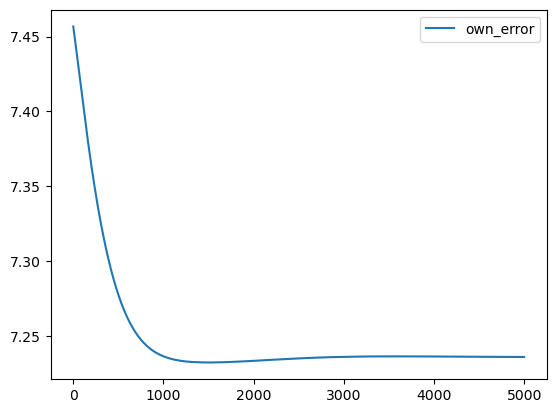

In [126]:
fig, ax = plt.subplots()
x_net = np.arange(0,5000,1)
ax.plot(x_net,error_own[0:5000], label='own_error')
ax.legend()

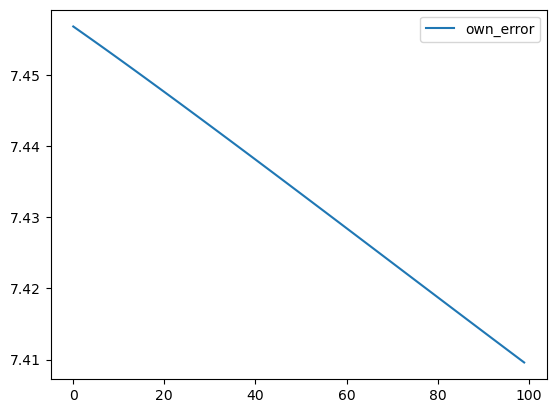

In [127]:
fig, ax = plt.subplots()
x_net = np.arange(0,100,1)
ax.plot(x_net,error_own[0:100], label='own_error')
ax.legend()

In [128]:
loss_own = net.loss.to("cpu").detach().numpy()

In [129]:
net_pinns.train()

0 0.35367676615715027
test_dxtorch.Size([100, 1]) test_dttorch.Size([100, 1]) test_dxdxtorch.Size([100, 1]) realvaluetorch.Size([100, 1]) realvalue_dttorch.Size([100, 1]) realvalue_dxtorch.Size([100, 1]) realvalue_dxdxtorch.Size([100, 1])
tensor([0.3537], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
100 0.3099426329135895
200 0.2716192305088043
300 0.23806627094745636
400 0.20868565142154694
500 0.18298906087875366
600 0.16056594252586365
700 0.14105099439620972
800 0.12410923838615417
900 0.10943320393562317
1000 0.09674051403999329
1100 0.085771344602108
1200 0.07628906518220901
1300 0.06807927042245865
1400 0.06095091253519058
1500 0.05473728105425835
1600 0.04929449409246445
1700 0.044500790536403656
1800 0.04025442898273468
1900 0.036471541970968246
2000 0.033083729445934296
2100 0.03003576584160328
2200 0.02728358842432499
2300 0.024791637435555458
2400 0.022531608119606972
2500 0.020480185747146606
2600 0.018618596717715263
2700 0.016930872574448586
2800 0.01540300901979208
29

In [130]:
error_pinns = net_pinns.error.to("cpu").detach().numpy()
np.savetxt('error_pinns_1', error_pinns)

In [131]:
error_pinns = np.loadtxt('error_pinns_1')
error_own = np.loadtxt('error_owm_1')

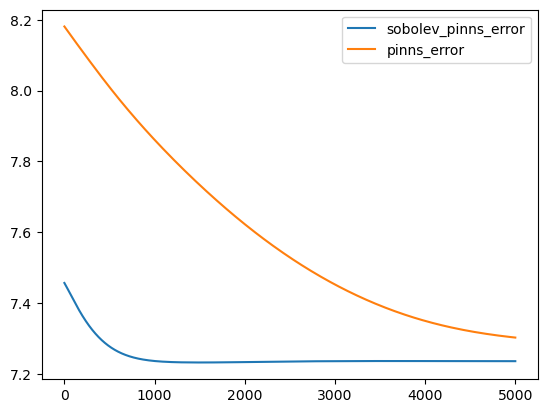

In [132]:
fig, ax = plt.subplots()
x_net = np.arange(0,5000,1)
x_pinns = np.arange(0,5000,1)
ax.plot(x_net,error_own[0:5000], label='sobolev_pinns_error')
ax.plot(x_pinns,error_pinns[0:5000], label = 'pinns_error')
ax.legend()

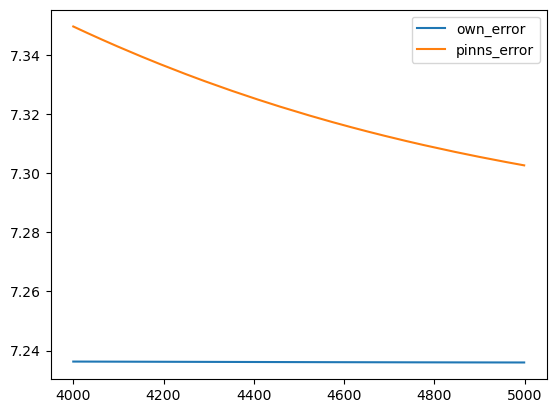

In [133]:
fig, ax = plt.subplots()
x_net = np.arange(4000,5000,1)
x_pinns = np.arange(4000,5000,1)
ax.plot(x_net,error_own[4000:5000], label='own_error')
ax.plot(x_pinns,error_pinns[4000:5000], label = 'pinns_error')
ax.legend()

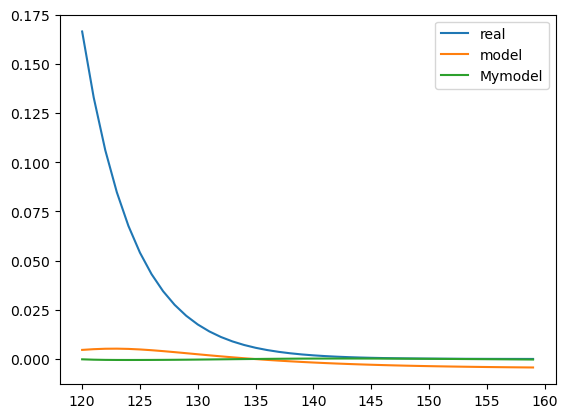

In [134]:
fig, ax = plt.subplots()
x_net = np.arange(120,160,1)
x_pinns = np.arange(120,160,1)
ax.plot(x_net,net.model.u_real(xt_In).to("cpu").detach().numpy()[120:160], label='real')
ax.plot(x_pinns,net_pinns.model(xt_In).to("cpu").detach().numpy()[120:160], label = 'model')
ax.plot(x_pinns,net.model(xt_In).to("cpu").detach().numpy()[120:160], label = 'Mymodel')
ax.legend()

In [135]:
torch.set_printoptions(threshold=10_000)
print(xt_In)

tensor([[0.0500, 0.5000],
        [0.0500, 0.7250],
        [0.0500, 0.9500],
        [0.0500, 1.1750],
        [0.0500, 1.4000],
        [0.0500, 1.6250],
        [0.0500, 1.8500],
        [0.0500, 2.0750],
        [0.0500, 2.3000],
        [0.0500, 2.5250],
        [0.0500, 2.7500],
        [0.0500, 2.9750],
        [0.0500, 3.2000],
        [0.0500, 3.4250],
        [0.0500, 3.6500],
        [0.0500, 3.8750],
        [0.0500, 4.1000],
        [0.0500, 4.3250],
        [0.0500, 4.5500],
        [0.0500, 4.7750],
        [0.0500, 5.0000],
        [0.0500, 5.2250],
        [0.0500, 5.4500],
        [0.0500, 5.6750],
        [0.0500, 5.9000],
        [0.0500, 6.1250],
        [0.0500, 6.3500],
        [0.0500, 6.5750],
        [0.0500, 6.8000],
        [0.0500, 7.0250],
        [0.0500, 7.2500],
        [0.0500, 7.4750],
        [0.0500, 7.7000],
        [0.0500, 7.9250],
        [0.0500, 8.1500],
        [0.0500, 8.3750],
        [0.0500, 8.6000],
        [0.0500, 8.8250],
        [0.0

In [136]:
xt_905 = torch.tensor([[0,0]]).to("cuda:0")
for i in xt_In:
    if (i[1] == 9.05):
        xt_905 = torch.cat((xt_905,i.unsqueeze(0)),0)
print(xt_905)

tensor([[0.0000, 0.0000],
        [0.0500, 9.0500],
        [0.1260, 9.0500],
        [0.2021, 9.0500],
        [0.2781, 9.0500],
        [0.3542, 9.0500],
        [0.4302, 9.0500],
        [0.5062, 9.0500],
        [0.5823, 9.0500],
        [0.6583, 9.0500],
        [0.7344, 9.0500],
        [0.8104, 9.0500],
        [0.8864, 9.0500],
        [0.9625, 9.0500],
        [1.0385, 9.0500],
        [1.1146, 9.0500],
        [1.1906, 9.0500],
        [1.2666, 9.0500],
        [1.3427, 9.0500],
        [1.4187, 9.0500],
        [1.4948, 9.0500],
        [1.5708, 9.0500],
        [1.6468, 9.0500],
        [1.7229, 9.0500],
        [1.7989, 9.0500],
        [1.8750, 9.0500],
        [1.9510, 9.0500],
        [2.0270, 9.0500],
        [2.1031, 9.0500],
        [2.1791, 9.0500],
        [2.2552, 9.0500],
        [2.3312, 9.0500],
        [2.4072, 9.0500],
        [2.4833, 9.0500],
        [2.5593, 9.0500],
        [2.6354, 9.0500],
        [2.7114, 9.0500],
        [2.7874, 9.0500],
        [2.8

In [137]:
xt_500 = torch.tensor([[0,0]]).to("cuda:0")
for i in xt_In:
    if (i[1] == 5.00):
        xt_500 = torch.cat((xt_500,i.unsqueeze(0)),0)
print(xt_500)

tensor([[0.0000, 0.0000],
        [0.0500, 5.0000],
        [0.1260, 5.0000],
        [0.2021, 5.0000],
        [0.2781, 5.0000],
        [0.3542, 5.0000],
        [0.4302, 5.0000],
        [0.5062, 5.0000],
        [0.5823, 5.0000],
        [0.6583, 5.0000],
        [0.7344, 5.0000],
        [0.8104, 5.0000],
        [0.8864, 5.0000],
        [0.9625, 5.0000],
        [1.0385, 5.0000],
        [1.1146, 5.0000],
        [1.1906, 5.0000],
        [1.2666, 5.0000],
        [1.3427, 5.0000],
        [1.4187, 5.0000],
        [1.4948, 5.0000],
        [1.5708, 5.0000],
        [1.6468, 5.0000],
        [1.7229, 5.0000],
        [1.7989, 5.0000],
        [1.8750, 5.0000],
        [1.9510, 5.0000],
        [2.0270, 5.0000],
        [2.1031, 5.0000],
        [2.1791, 5.0000],
        [2.2552, 5.0000],
        [2.3312, 5.0000],
        [2.4072, 5.0000],
        [2.4833, 5.0000],
        [2.5593, 5.0000],
        [2.6354, 5.0000],
        [2.7114, 5.0000],
        [2.7874, 5.0000],
        [2.8

In [138]:
xt_0725 = torch.tensor([[0,0]]).to("cuda:0")
for i in xt_In:
    if (i[1] == 0.7250):
        xt_0725 = torch.cat((xt_0725,i.unsqueeze(0)),0)

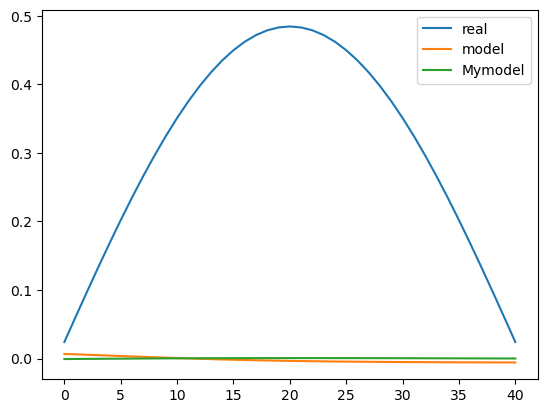

In [139]:
fig, ax = plt.subplots()
x_net = np.arange(0,41,1)
x_pinns = np.arange(0,41,1)
ax.plot(x_net,net.model.u_real(xt_0725[1::]).to("cpu").detach().numpy()[0:41], label='real')
ax.plot(x_pinns,net_pinns.model(xt_0725[1::]).to("cpu").detach().numpy()[0:41], label = 'model')
ax.plot(x_pinns,net.model(xt_0725[1::]).to("cpu").detach().numpy()[0:41], label = 'Mymodel')
ax.legend()

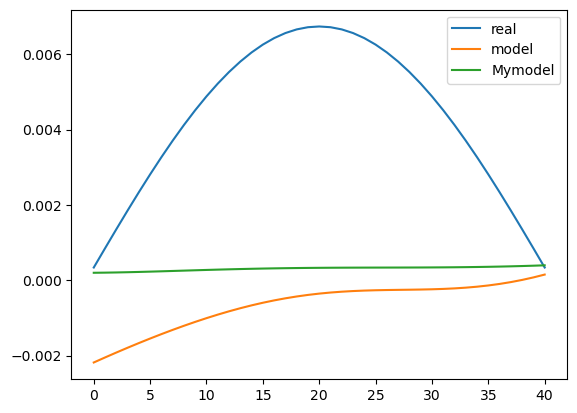

In [140]:
fig, ax = plt.subplots()
x_net = np.arange(0,41,1)
x_pinns = np.arange(0,41,1)
ax.plot(x_net,net.model.u_real(xt_500[1::]).to("cpu").detach().numpy()[0:41], label='real')
ax.plot(x_pinns,net_pinns.model(xt_500[1::]).to("cpu").detach().numpy()[0:41], label = 'model')
ax.plot(x_pinns,net.model(xt_500[1::]).to("cpu").detach().numpy()[0:41], label = 'Mymodel')
ax.legend()

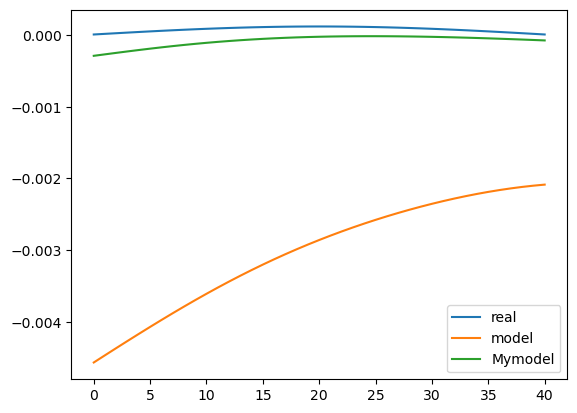

In [141]:
fig, ax = plt.subplots()
x_net = np.arange(0,41,1)
x_pinns = np.arange(0,41,1)
ax.plot(x_net,net.model.u_real(xt_905[1::]).to("cpu").detach().numpy()[0:42], label='real')
ax.plot(x_pinns,net_pinns.model(xt_905[1::]).to("cpu").detach().numpy()[0:42], label = 'model')
ax.plot(x_pinns,net.model(xt_905[1::]).to("cpu").detach().numpy()[0:42], label = 'Mymodel')
ax.legend()

In [169]:
L2 = torch.nn.MSELoss()
relative_error_net = L2(net.model.u_real(xt_905),net.model(xt_905)) / L2(net.model.u_real(xt_905),torch.zeros_like(net.model.u_real(xt_905)))
relative_error_pinns = L2(net.model.u_real(xt_905),net_pinns.model(xt_905)) / L2(net_pinns.model.u_real(xt_905),torch.zeros_like(net_pinns.model.u_real(xt_905)))
print(relative_error_net,relative_error_pinns)

tensor(4.6120, device='cuda:0', grad_fn=<DivBackward0>) tensor(1546.8057, device='cuda:0', grad_fn=<DivBackward0>)


In [174]:
print(torch.max(net.model.u_real(xt_905)-net.model(xt_905)))
print(torch.max(net.model.u_real(xt_905)))

tensor(0.0004, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0001, device='cuda:0', grad_fn=<MaxBackward1>)


In [142]:
print(net.realvalue.size())

torch.Size([100, 1])


In [143]:
print(np.arange(0,10,1))

[0 1 2 3 4 5 6 7 8 9]


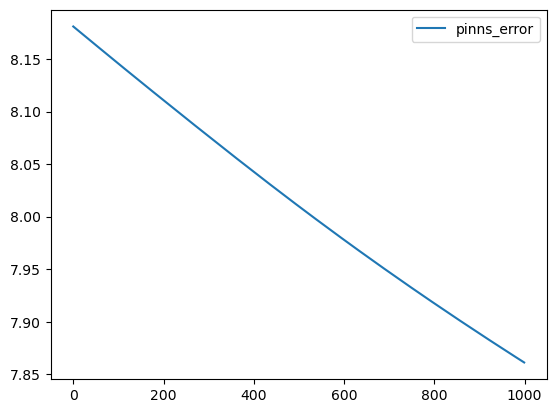

In [144]:
fig, ax = plt.subplots()
x_net = np.arange(0,1000,1)
ax.plot(x_net,error_pinns[0:1000], label='pinns_error')
ax.legend()

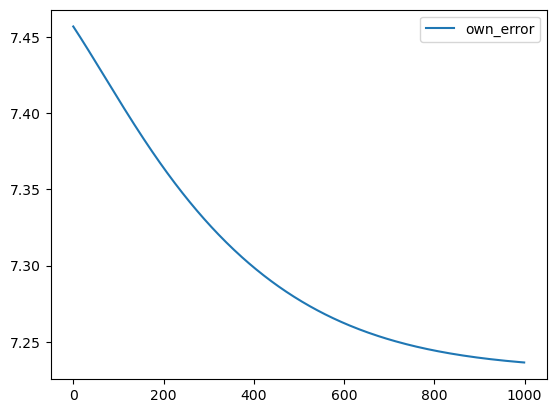

In [145]:
fig, ax = plt.subplots()
x_net = np.arange(0,1000,1)
ax.plot(x_net,error_own[0:1000], label='own_error')
ax.legend()

# Evaluate
- 构造测试集
- evalua

In [146]:
x_test = np.arange(0,np.pi,0.14)
t = np.arange(0,10,0.6)
x_test_tensor = torch.from_numpy(x_test).unsqueeze(1)
t_tensor = torch.from_numpy(t).unsqueeze(1)

In [147]:
print(t_tensor.size(),x_test_tensor.size())

torch.Size([17, 1]) torch.Size([23, 1])


In [148]:
xt_x_test_tensor = x_test_tensor.detach()
xt_t_tensor = t_tensor.detach()
print(xt_x_test_tensor.size(),xt_t_tensor.size())
for i in range(16):
    xt_x_test_tensor = torch.cat((xt_x_test_tensor,x_test_tensor),0)
for i in range(22):
    xt_t_tensor = torch.cat((xt_t_tensor,t_tensor),0)
print(xt_t_tensor.size(),xt_x_test_tensor.size())
xt_test_tensor = torch.cat((xt_x_test_tensor,xt_t_tensor),1)
xt_test_tensor = xt_test_tensor.to("cuda").to(torch.float32)
print(xt_test_tensor.size())

torch.Size([23, 1]) torch.Size([17, 1])
torch.Size([391, 1]) torch.Size([391, 1])
torch.Size([391, 2])


In [149]:
net.eval_()
net_testvalue = net.model(xt_test_tensor)
net_pinns.eval_()
net_pinns_testvalue = net_pinns.model(xt_test_tensor)
print(net_testvalue.size(),net_pinns_testvalue.size())

torch.Size([391, 1]) torch.Size([391, 1])


In [150]:
print(net.model(torch.tensor([3.,7.]).to("cuda")))
print(net_pinns.model(torch.tensor([3.,7.]).to("cuda")))
print(torch.sin(torch.tensor(3.))*torch.exp(torch.tensor(-7.)))

tensor([0.0002], device='cuda:0', grad_fn=<AddBackward0>)
tensor([-0.0014], device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001)


In [151]:
print(net.model(torch.tensor([1.,8.]).to("cuda")))
print(net_pinns.model(torch.tensor([1.,8.]).to("cuda")))
print(torch.sin(torch.tensor(3.))*torch.exp(torch.tensor(-7.)))

tensor([0.0001], device='cuda:0', grad_fn=<AddBackward0>)
tensor([-0.0030], device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001)


In [152]:
print(net.model(torch.tensor([torch.pi,8.]).to("cuda")))
print(net_pinns.model(torch.tensor([torch.pi,8.]).to("cuda")))
print(torch.sin(torch.tensor(0))*torch.exp(torch.tensor(-7.)))

tensor([6.0473e-05], device='cuda:0', grad_fn=<AddBackward0>)
tensor([-0.0018], device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.)


In [153]:
print(net.loss,net_pinns.loss)

tensor([3.8825e-02, 3.8662e-02, 3.8500e-02, 3.8339e-02, 3.8178e-02, 3.8019e-02,
        3.7860e-02, 3.7701e-02, 3.7544e-02, 3.7387e-02, 3.7231e-02, 3.7076e-02,
        3.6921e-02, 3.6767e-02, 3.6614e-02, 3.6462e-02, 3.6310e-02, 3.6159e-02,
        3.6009e-02, 3.5860e-02, 3.5712e-02, 3.5564e-02, 3.5417e-02, 3.5271e-02,
        3.5125e-02, 3.4981e-02, 3.4837e-02, 3.4694e-02, 3.4552e-02, 3.4410e-02,
        3.4269e-02, 3.4130e-02, 3.3990e-02, 3.3852e-02, 3.3714e-02, 3.3577e-02,
        3.3441e-02, 3.3306e-02, 3.3171e-02, 3.3037e-02, 3.2904e-02, 3.2771e-02,
        3.2640e-02, 3.2509e-02, 3.2378e-02, 3.2249e-02, 3.2120e-02, 3.1992e-02,
        3.1864e-02, 3.1737e-02, 3.1611e-02, 3.1486e-02, 3.1361e-02, 3.1237e-02,
        3.1114e-02, 3.0991e-02, 3.0869e-02, 3.0748e-02, 3.0627e-02, 3.0507e-02,
        3.0387e-02, 3.0268e-02, 3.0150e-02, 3.0032e-02, 2.9915e-02, 2.9799e-02,
        2.9683e-02, 2.9568e-02, 2.9453e-02, 2.9339e-02, 2.9226e-02, 2.9113e-02,
        2.9001e-02, 2.8889e-02, 2.8778e-

In [154]:
print(net.realvalue,net.model(net.xt_test))

tensor([[0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [3.0902e-01],
        [1.1368e-01],
        [4.1821e-02],
        [1.5385e-02],
        [5.6598e-03],
        [2.0821e-03],
        [7.6598e-04],
        [2.8179e-04],
        [1.0366e-04],
        [3.8136e-05],
        [5.8779e-01],
        [2.1623e-01],
        [7.9548e-02],
        [2.9264e-02],
        [1.0766e-02],
        [3.9605e-03],
        [1.4570e-03],
        [5.3599e-04],
        [1.9718e-04],
        [7.2538e-05],
        [8.0902e-01],
        [2.9762e-01],
        [1.0949e-01],
        [4.0279e-02],
        [1.4818e-02],
        [5.4511e-03],
        [2.0054e-03],
        [7.3773e-04],
        [2.7139e-04],
        [9.9841e-05],
        [9.5106e-01],
        [3.4987e-01],
        [1.2871e-01],
        [4.7350e-02],
        [1.7419e-02],
        [6

In [155]:
realvalue = torch.sin(xt_test_tensor[:,0])*torch.exp(-xt_test_tensor[:,1])
realvalue = realvalue.unsqueeze(1)
print(realvalue.size())

torch.Size([391, 1])


In [156]:
L2norm = nn.MSELoss()
net_error = L2norm(realvalue,net_testvalue)
pinns_error = L2norm(realvalue,net_pinns_testvalue)
print(f"net's error{net_error}")
print(f"pinns's error{pinns_error}")

net's error0.040924783796072006
pinns's error0.04135311394929886


In [157]:
net_xt = xt_test_tensor.detach().to("cuda")
pinns_xt = xt_test_tensor.detach().to("cuda")
net_xt.requires_grad_()
pinns_xt.requires_grad_()

tensor([[0.0000, 0.0000],
        [0.1400, 0.6000],
        [0.2800, 1.2000],
        [0.4200, 1.8000],
        [0.5600, 2.4000],
        [0.7000, 3.0000],
        [0.8400, 3.6000],
        [0.9800, 4.2000],
        [1.1200, 4.8000],
        [1.2600, 5.4000],
        [1.4000, 6.0000],
        [1.5400, 6.6000],
        [1.6800, 7.2000],
        [1.8200, 7.8000],
        [1.9600, 8.4000],
        [2.1000, 9.0000],
        [2.2400, 9.6000],
        [2.3800, 0.0000],
        [2.5200, 0.6000],
        [2.6600, 1.2000],
        [2.8000, 1.8000],
        [2.9400, 2.4000],
        [3.0800, 3.0000],
        [0.0000, 3.6000],
        [0.1400, 4.2000],
        [0.2800, 4.8000],
        [0.4200, 5.4000],
        [0.5600, 6.0000],
        [0.7000, 6.6000],
        [0.8400, 7.2000],
        [0.9800, 7.8000],
        [1.1200, 8.4000],
        [1.2600, 9.0000],
        [1.4000, 9.6000],
        [1.5400, 0.0000],
        [1.6800, 0.6000],
        [1.8200, 1.2000],
        [1.9600, 1.8000],
        [2.1

In [158]:
net_dx = torch.autograd.grad(inputs=net_xt, outputs=net.model(net_xt),
                                                 grad_outputs=torch.ones_like(net.model(net_xt)),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
net_dt = torch.autograd.grad(inputs=net_xt, outputs=net.model(net_xt),
                                                 grad_outputs=torch.ones_like(net.model(net_xt)),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,1].unsqueeze(1)
net_dxdx = torch.autograd.grad(inputs=net_xt, outputs=net_dx,
                                                 grad_outputs=torch.ones_like(net_dx),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)

In [159]:
pinns_dx = torch.autograd.grad(inputs=pinns_xt, outputs=net_pinns.model(pinns_xt),
                                                 grad_outputs=torch.ones_like(net_pinns.model(pinns_xt)),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
pinns_dt = torch.autograd.grad(inputs=pinns_xt, outputs=net_pinns.model(pinns_xt),
                                                 grad_outputs=torch.ones_like(net_pinns.model(pinns_xt)),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,1].unsqueeze(1)
pinns_dxdx = torch.autograd.grad(inputs=pinns_xt, outputs=pinns_dx,
                                                 grad_outputs=torch.ones_like(pinns_dx),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)

In [160]:
realvalue_dt = -realvalue.detach().to("cuda")
realvalue_dxdx = -realvalue.detach().to("cuda")
realvalue_dx = (torch.cos(xt_test_tensor[:,0])*torch.exp(-xt_test_tensor[:,1])).unsqueeze(1)
print(realvalue_dx.size())

torch.Size([391, 1])


In [161]:
net_w21norm = net_error+L2norm(realvalue_dt,net_dt)+L2norm(realvalue_dx,net_dx)+L2norm(realvalue_dxdx,net_dxdx)
pinns_w21norm = pinns_error+L2norm(realvalue_dt,pinns_dt)+L2norm(realvalue,pinns_dx)+L2norm(realvalue_dxdx,pinns_dxdx)
print(f"net_w21norm's error {net_w21norm}")
print(f"pinns_w21norm's error {pinns_w21norm}")

net_w21norm's error 0.16561967134475708
pinns_w21norm's error 0.16536565124988556


In [162]:
testx = torch.tensor([1.,2.],requires_grad=True,device="cuda")
net.model(testx)

tensor([-0.0003], device='cuda:0', grad_fn=<AddBackward0>)

In [163]:
testdx = torch.autograd.grad(inputs=testx, outputs=net.model(testx),
                                                 grad_outputs=torch.ones_like(net.model(testx)),
                                                 retain_graph=True,
                                                 create_graph=True)
print(testdx)

(tensor([ 0.0003, -0.0002], device='cuda:0', grad_fn=<SqueezeBackward1>),)


# Plot
